## 1. Excercise

In [31]:
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Input # type: ignore
from tensorflow.keras.datasets import mnist # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore


In [32]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_visible_devices(tf.config.list_physical_devices('GPU'), 'GPU')
    print("GPU detected, running on GPU.")
else:
    print("No GPU detected, running on CPU.")


GPU detected, running on GPU.


In [33]:
# 1. loading the data

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], -1).astype("float32") / 255
x_test = x_test.reshape(x_test.shape[0], -1).astype("float32") / 255

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [34]:
# 2. neural network

def create_model():
    model = Sequential()
    model.add(Input(shape=(28 * 28,)))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(10, activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
    return model

In [35]:
# 3. fitness function

def fitness(weights):
    model = create_model()
    model.set_weights(weights)
    history = model.fit(x_train, y_train, 
                        epochs=1, batch_size=128, 
                        validation_data=(x_test, y_test),
                        verbose=0)
    acc = history.history["accuracy"][-1]
    loss = history.history["loss"][-1]
    val_acc = history.history["val_accuracy"][-1]
    val_loss = history.history["val_loss"][-1]
    
    print(f"Accuracy: {acc}, loss: {loss}, Validation accuracy: {val_acc}, Validation loss: {val_loss}")
    print()
    return acc, loss, val_acc, val_loss

In [36]:
# 4. population initialization

def init_population(pop_size, weight_shapes):
    populations = []
    for _ in range(pop_size):
        individual = []
        for shape in weight_shapes:
            individual.append(np.random.randn(*shape))
        populations.append(individual)
    return populations



In [37]:
# 5. selection

def select_parents(population, fitnesses):
    sorted_population = sorted(zip(population, fitnesses), key=lambda x: x[1], reverse=True)
    return[ind[0] for ind in sorted_population[:2]]

In [38]:
# 6. crossover

def crossover(parent1, parent2):
    child = []
    for w1, w2 in zip(parent1, parent2):
        crossover_point = random.randint(0, len(w1)-1)
        child.append(np.concatenate((w1[:crossover_point], w2[crossover_point:])))
    return child

In [39]:
# 7. mutation

def mutation(individual, mutation_rate=0.1):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            individual[i] += np.random.randn(*individual[i].shape) * 0.1
    return individual

In [40]:
# 8. evolution

def algorithm(pop_size, weight_shapes, num_generations, mutation_rate):
    population = init_population(pop_size, weight_shapes)
    best_fitnesses = 0
    best_individual = None

    accuracy_list = []
    losses_list = []
    val_accuracy_list = []
    val_losses_list = []

    for generation in range(num_generations):
        print(f"Generation: {(generation+1)}/{num_generations}")
        fitnesses = [fitness(ind) for ind in population]
        best_gen_individual = population[fitnesses.index(max(fitnesses, key=lambda x: x[0]))]
        best_gen_acc, best_gen_loss, best_gen_val_acc, best_gen_val_loss = max(fitnesses, key=lambda x: x[0])

        accuracy_list.append(best_gen_acc)
        losses_list.append(best_gen_loss)
        val_accuracy_list.append(best_gen_val_acc)
        val_losses_list.append(best_gen_val_loss)


        print("Best accuracy:", best_gen_acc, "Best loss:", best_gen_loss)
        print("Best val accuracy:", best_gen_val_acc, "Best val loss:", best_gen_val_loss)
        print()
        
        if best_gen_acc > best_fitnesses:
            best_fitnesses = best_gen_acc
            best_individual = best_gen_individual

        # selection
        parents = select_parents(population, [fit[0] for fit in fitnesses])

        # crossover and mutation
        next_generation = []
        
        for _ in range(pop_size//2):
            parent1, parent2 = random.sample(parents, 2)
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent2, parent1)


            next_generation.append(mutation(child1, mutation_rate))
            next_generation.append(mutation(child2, mutation_rate))
        

        # replace the population
        population = next_generation
        
    return best_individual, best_fitnesses, accuracy_list, losses_list, val_accuracy_list, val_losses_list

Generation: 1/5


I0000 00:00:1732730831.497862  102930 service.cc:148] XLA service 0x72b5100060f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732730831.497894  102930 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce MX150, Compute Capability 6.1
2024-11-27 20:07:11.522041: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732730831.626309  102930 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1732730832.685145  102930 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Accuracy: 0.604449987411499, loss: 18.057716369628906, Validation accuracy: 0.7932000160217285, Validation loss: 5.80794620513916

Accuracy: 0.6146666407585144, loss: 15.505701065063477, Validation accuracy: 0.802299976348877, Validation loss: 5.2601189613342285

Accuracy: 0.6081500053405762, loss: 17.89252471923828, Validation accuracy: 0.8030999898910522, Validation loss: 5.59536600112915

Accuracy: 0.577750027179718, loss: 18.823225021362305, Validation accuracy: 0.7910000085830688, Validation loss: 5.677799224853516

Accuracy: 0.5603500008583069, loss: 19.750391006469727, Validation accuracy: 0.7846999764442444, Validation loss: 5.850368976593018

Accuracy: 0.6273166537284851, loss: 15.393304824829102, Validation accuracy: 0.8007000088691711, Validation loss: 5.415224075317383

Accuracy: 0.593916654586792, loss: 18.700044631958008, Validation accuracy: 0.7832000255584717, Validation loss: 6.054754257202148

Accuracy: 0.5974500179290771, loss: 20.440601348876953, Validation accuracy

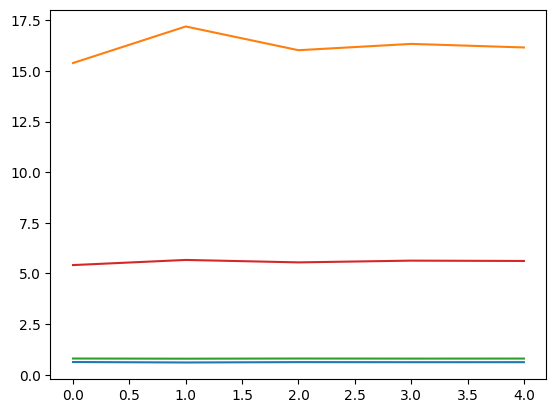

In [41]:
# 9. init and run the algorithm

weight_shapes = [(784, 128), (128, ), (128, 10), (10, )]
pop_size = 10
num_generations = 5
mutation_rate = 0.1

best_individual, best_fitnesses, accuracy_list, losses_list, val_accuracy_list, val_losses_list = algorithm(pop_size, weight_shapes, num_generations, mutation_rate)

print("Best individual:", best_individual)
print("Best fitness:", best_fitnesses)

plt.plot(accuracy_list)
plt.plot(losses_list)
plt.plot(val_accuracy_list)
plt.plot(val_losses_list)
plt.show()